In [1]:
pip install openseespy

Note: you may need to restart the kernel to use updated packages.


## **Modeling this Turbine**
**65-kW Wind Turbine courtesy of UCSD**
<img src='Research\Turbine.PNG' width="300" height="300">

16
Natural Frequencies: [1.7571786135902587, 1.7571786135902587, 12.832015267493928, 12.832015267493945, 31.944136983453696, 37.07707041159174, 37.07707041159182, 79.2284051329484, 79.22840513294864, 106.31769279436006] Hz
No Model_ODB specified, trying to get data from the active model.
3D model


<IPython.core.display.Javascript object>


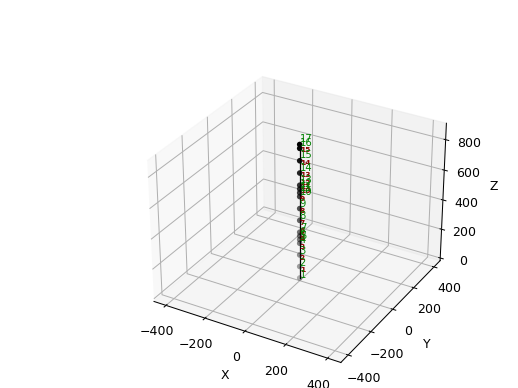

No Model_ODB specified to plot modeshapes
3D model


<IPython.core.display.Javascript object>


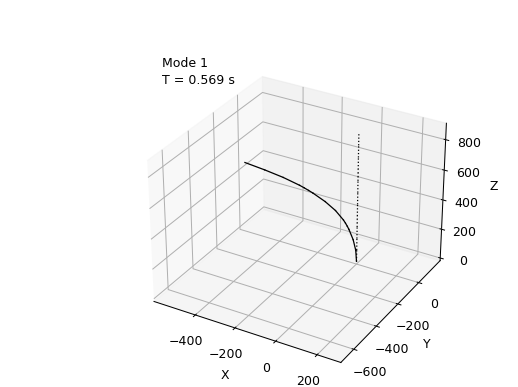

17
863.0


In [58]:
# following example on http://opensees.berkeley.edu/wiki/index.php/Elastic_Frame_Example
# running dynamic ground motion

%matplotlib notebook

# import OpenSees and libraries
from openseespy.opensees import *
from openseespy.postprocessing.Get_Rendering import *

# numerical and plotting tools
import numpy as np
import matplotlib.pyplot as plt
import math

# system commands
import os, os.path
import glob
import shutil

# -------------------------------
#       Generate Model
# -------------------------------

# remove existing model
wipe()

# remove existing results
# explanation here: https://stackoverflow.com/a/31989328
def remove_thing(path):
    if os.path.isdir(path):
        shutil.rmtree(path)
    else:
        os.remove(path)

def empty_directory(path):
    for i in glob.glob(os.path.join(path, '*')):
        remove_thing(i)

empty_directory('modes')
empty_directory('output')

# ------------------------------------
#   Generate model and static analysis
# ------------------------------------

# set modelbuilder
model('basic', '-ndm', 3, '-ndf', 6)

# units: in, kip, s
# dimensions
ft = 12.0
inch = 1.0
g = 386.1 #in/s^2
kip = 1.0
ksi = kip/(inch**2)

# material properties
Es = 29000*ksi
Gs = 11500*ksi

###########################################################################################
# create nodes
###########################################################################################
# command: node(nodeID, x-coord, y-coord, z-coord)
# command: node(nodeTag, *crds, '-ndf', ndf, '-mass', *mass, '-disp', *disp, '-vel', *vel, '-accel', *accel)
# Note: Ian Prowell Dissertation: Split into 30 beam-column elements

# specify number of elements of each portion of the tower
eldiv = 3

# Defining the first node
nodeTag = 1
node(nodeTag, 0.0, 0.0, 0.0)

# Heights of tower sections
hbot = 238.2*inch
hbottap = 74.8*inch
hmid = 237.2*inch
hmidtap = 74.8*inch
htop = 238*inch

# Lower tower section (Split into eldiv elements)
for j in range(eldiv):
    nodeTag += 1
    h = (hbot/eldiv)*(j + 1)
    node(nodeTag, 0.0, 0.0, h)
    
# Tapered lower section (Split into eldiv elements)
for j in range(eldiv):
    nodeTag += 1
    h = hbot + (hbottap/eldiv)*(j + 1)
    node(nodeTag, 0.0, 0.0, h)

# Middle tower section (Split into eldiv elements)
for j in range(eldiv):
    nodeTag += 1
    h = hbot + hbottap + (hmid/eldiv)*(j + 1)
    node(nodeTag, 0.0, 0.0, h)

# Tapered middle section (Split into eldiv elements)
for j in range(eldiv):
    nodeTag += 1
    h = hbot + hbottap + hmid + (hmidtap/eldiv)*(j + 1)
    node(nodeTag, 0.0, 0.0, h)
    
# Top tower section (Split into eldiv elements)
for j in range(eldiv):
    nodeTag += 1
    h = hbot + hbottap + hmid + hmidtap + (htop/eldiv)*(j + 1)
    node(nodeTag, 0.0, 0.0, h)
    
print(nodeTag)
# restraints
# command: fix(nodeID, DOF1, DOF2, DOF3, DOF4, DOF5, DOF6) 0 = free, 1 = fixed
# Use a fixed connection for now
fix(1, 1, 1, 1, 1, 1, 1)

# geometric transformation for beam-columns
# command: geomTransf('Type', TransfTag)
# see https://opensees.berkeley.edu/wiki/index.php/Linear_Transformation 
geomTransf('PDelta', 1, 0, 1, 0) #columns

###########################################################################################
# define elements                                                                              
###########################################################################################


# initialize lists
D = [] # diameters in
A = [] # areas in^2
I = [] # area moment of inertia in^4
J = [] # polar moment of inertia in^4
dM = [] # distributed masses kip*s^2/in
V = [] # volumes in^3
H = [] # height of each element in
t = 0.21*inch # thickness is constant


# Determining the diameters, areas, area moment of inertias, and polar moments of each discretized tower segment
# diameters of tower
dbot = 79.5*inch
dmid = 62.1*inch
dtop = 47.2*inch

index = 0

# Lower tower section (Split into eldiv elemenets)
for j in range(eldiv):
    H.append(hbot/eldiv)
    D.append(dbot)
    A.append(((D[index])**2 - (D[index] - (2*t))**2)*math.pi/4)
    I.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/64)
    J.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/32)
    index += 1

# Tapered lower section (Split into eldiv elements)
for j in range(eldiv):
    H.append(hbottap/eldiv)
    d = ((j + 1)/(2*eldiv))*(dmid-dbot) + dbot # interpolating for the diameter based on eldiv
    D.append(d)
    A.append(((D[index])**2 - (D[index] - 2*t)**2)*math.pi/4)
    I.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/64)
    J.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/32)
    index += 1

# Middle tower section (Split into eldiv elements)
for j in range(eldiv):
    H.append(hmid/eldiv)
    D.append(dmid)
    A.append(((D[index])**2 - (D[index] - 2*t)**2)*math.pi/4)
    I.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/64)
    J.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/32)
    index += 1

# Tapered middle section (Split into eldiv elements)
for j in range(eldiv):
    H.append(hmidtap/eldiv)
    d = ((j + 1)/(2*eldiv))*(dtop-dmid) + dmid # interpolating for the diameter based on eldiv
    D.append(d)
    A.append(((D[index])**2 - (D[index] - 2*t)**2)*math.pi/4)
    I.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/64)
    J.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/32)
    index += 1
    
# Top tower section
for j in range(eldiv):
    H.append(htop/eldiv)
    D.append(dtop)
    A.append(((D[index])**2 - (D[index] - 2*t)**2)*math.pi/4)
    I.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/64)
    J.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/32)
    index += 1
    
# Determining volumes of tower segments
index = 0

# Lower tower section (Split into eldiv elemenets)
for j in range(eldiv):
    v = math.pi*(hbot/eldiv)*(D[index]**2 - (D[index]-2*t)**2)/4
    V.append(v)
    index += 1
    
# Tapered lower section (Split into eldiv elements)
for j in range(eldiv):
    dlower = ((dmid-dbot)*j)/(eldiv) + dbot
    dhigher = ((dmid-dbot)*(j+1))/(eldiv) + dbot
    v = math.pi*(hbottap/eldiv)*((dlower**2 +dlower*dhigher + dhigher**2)-((dlower-2*t)**2 + (dlower-2*t)*(dhigher-2*t) + (dhigher-2*t)**2))/12
    V.append(v)
    index += 1    

# Middle tower section (Split into eldiv elements)
for j in range(eldiv):
    v = math.pi*(hmid/eldiv)*(D[index]**2 - (D[index]-2*t)**2)/4
    V.append(v)
    index += 1
    
# Tapered middle section (Split into eldiv elements)
for j in range(eldiv):
    dlower = ((dtop-dmid)*j)/(eldiv) + dmid
    dhigher = ((dtop-dmid)*(j+1))/(eldiv) + dmid
    v = math.pi*(hmidtap/eldiv)*((dlower**2 +dlower*dhigher + dhigher**2)-((dlower-2*t)**2 +(dlower-2*t)*(dhigher-2*t) + (dhigher-2*t)**2))/12
    V.append(v)
    index += 1    

# Top tower section (Split into eldiv elements)
for j in range(eldiv):
    v = math.pi*(htop/eldiv)*(D[index]**2 - (D[index]-2*t)**2)/4
    V.append(v)
    index += 1


mtotal = 14.101*kip/g
vtotal = sum(V)
htotal = hbot + hbottap + hmid + hmidtap + htop

# Determining distributed masses of tower segments
# Entire tower section (Split into 5*eldiv elemenets)
for j in range(len(H)):
    distm = (mtotal*V[j])/(vtotal*H[j]) # mass/height constant
    dM.append(distm)
    
# Defining the elements and determining areas, area moment of inertias, and polar inertias for each section
# Cylindrical sections => Ix = Iy 
# Cylindrical sections => J = Iz = 2*Ix = (D^4-(D-t)^4)*(pi/32) 

# Assigning element properties
# create elastic beam-column elements - 
# command: element('elasticBeamColumn', eleTag, *eleNodes, Area, E_mod, G_mod, Jxx, Iy, Iz, transfTag, <'-mass', mass>, <'-cMass'>)
# define the columns  
for j in range(len(H)):
    element('elasticBeamColumn', j+1, j+1, j+2, A[j], Es, Gs, J[j], I[j], I[j], 1, '-mass', dM[j])

# Uncomment to see how the turbine twists
#node(nodeTag +1, 0.0, 10.0*ft, h)
#geomTransf('Linear', 2, 0, 0, 1) #columns
#element('elasticBeamColumn', len(H) + 1, len(H) + 1, len(H) + 2, A[len(H)-2], Es, Gs, J[len(H)-2], I[len(H)-2], I[len(H)-2], 2, '-mass', dM[len(H)-2])
    
# assign additional masses
# masses only act at nodes that have DoF
# command: mass(nodeID, dx, dy, dz, r@x, r@y, r@z)
# rotational inertia for a point mass: I = mr^2
whub = 9.4*kip
mhub = whub/g #kip*s^2/in
### to-do: the box is slightly higher than the last node of the tower, should we add another node? how would it be connected to the rest of the tower?
hhub = 888*inch # height of hub
node(len(H) + 2, 0.0, 0.0, hhub)
rigidLink('beam', len(H)+1, len(H)+2)
mass(len(H) + 2, mhub, mhub, mhub, 0.0, 0.0, 0.0)

# -------------------------------
#       Perform eigen analysis
# -------------------------------

numEigen = 10
eigenValues = eigen(numEigen)

wn = [i ** 0.5 for i in eigenValues]
fn = [i / (2*math.pi) for i in wn]

print("Natural Frequencies:", fn, "Hz")


#### Display the active model with node and element tags
plot_model("nodes","elements")

plot_modeshape(1, 100)

print(len(H)+2)
print(htotal)
